# Import thư viện

In [1]:
import os
import sys
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

prj_path = os.path.join(os.path.abspath(''), '..')
if prj_path not in sys.path:
    sys.path.append(prj_path)

# tracker
import importlib
from pathlib import Path
from collections import OrderedDict
from lib.test.evaluation.environment import env_settings

from lib.test.evaluation import get_dataset
from lib.test.evaluation.running_2023 import run_dataset
from lib.test.evaluation import Sequence, Tracker

In [2]:
dataset_name = 'vot23'
tracker_name = 'procontext'
tracker_param = 'procontext'

# Chỉ xét bus

In [3]:
dataset = get_dataset(dataset_name)

for x in dataset:
    if x.name == 'bus':
        dataset = [x]

dataset

23 <class 'lib.test.evaluation.data.SequenceList'>


[Sequence bus, length=8087 frames]

In [4]:
len(dataset[0].init_bbox())

2

# Tạo 1 wapper mới cho tracker

In [5]:
class Tracker:
    """Wraps the tracker for evaluation and running purposes.
    
    args:
        name: Name of tracking method.
        parameter_name: Name of parameter file.
        run_id: The run id.
        display_name: Name to be displayed in the result plots.
    """
    def __init__(self, name: str, parameter_name: str, dataset_name: str, seq: Sequence, run_id: int = None, display_name: str = None,
                 result_only=False, debug=None):
        assert run_id is None or isinstance(run_id, int)

        self.name = name
        self.seq = seq
        self.seq_name = seq.name
        self.parameter_name = parameter_name
        self.dataset_name = dataset_name
        self.run_id = run_id    # Đây chính là seq_obj_id, id của từng đối tượng riêng biệt
        self.display_name = display_name
        self.output_boxes = []

        env = env_settings()
        if self.run_id is None:
            self.results_dir = '{}/{}/{}'.format(env.results_path, self.name, self.parameter_name)
        else:   # <--- từng tracker cho từng object chạy vào đây
            self.results_dir = '{}/{}/{}/{:03d}'.format(env.results_path, self.name, self.seq_name, self.run_id)
        if result_only:
            self.results_dir = '{}/{}'.format(env.results_path, self.name)
        
        tracker_module_abspath = os.path.abspath(os.path.join(os.path.abspath(''), '..',
                                                              'lib', 'test', 'tracker', '%s.py' % self.name))
        if os.path.isfile(tracker_module_abspath):
            tracker_module = importlib.import_module('lib.test.tracker.{}'.format(self.name))
            self.tracker_class = tracker_module.get_tracker_class()
        else:
            self.tracker_class = None
        
#     def initialize(self, debug=None):
        # initialize
        params = self.get_parameters()
        
        debug_ = debug
        if debug is None:
            debug_ = getattr(params, 'debug', 0)
        
        params.debug = debug_
        
        # Get init info
        temp_info = self.seq.init_info()
        temp_info['init_bbox'] = temp_info['init_bbox'][self.run_id]
        self.init_info = temp_info
        self.output_boxes.append([int(i) for i in self.init_info['init_bbox']])
        print("Init info: ", self.init_info)
        
        self.tracker = self.create_tracker(params)
        
        # Initialize tracker
        image = self._read_image(self.seq.frames[0])
        out = self.tracker.initialize(image, self.init_info)
        if out is None:
            out = {}
        
        self.prev_output = OrderedDict(out)
            
    def track(self, frame_num:int, frame_path:str):
        image = self._read_image(frame_path)
        
        start_time = time.time()
        
        info = self.seq.frame_info(frame_num)
        info['previous_output'] = self.prev_output
        out = self.tracker.track(image, info)
        self.prev_output = OrderedDict(out)
        
        state = [int(s) for s in out['target_bbox']]
        self.output_boxes.append(state)
        return state
    
    def create_tracker(self, params):
        tracker = self.tracker_class(params, self.dataset_name)
        return tracker
    
    def get_parameters(self):
        param_module = importlib.import_module('lib.test.parameter.{}'.format(self.name))
        params = param_module.parameters(self.parameter_name)
        return params
    
    def _read_image(self, image_file: str):
        if isinstance(image_file, str):
            im = cv2.imread(image_file)
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        elif isinstance(image_file, list) and len(image_file) == 2:
            return decode_img(image_file[0], image_file[1])
        else:
            raise ValueError("type of image_file should be str or list")

In [6]:
wrapper = Tracker(tracker_name, tracker_param, dataset_name, dataset[0], 1)

Init info:  {'init_bbox': [642.0, 315.0, 78.0, 128.0]}
[642.0, 315.0, 78.0, 128.0]


In [7]:
wrapper.tracker_class

lib.test.tracker.procontext.ProContEXT

In [8]:
state = wrapper.track(2, dataset[0].frames[2])
state

[640, 313, 78, 129]

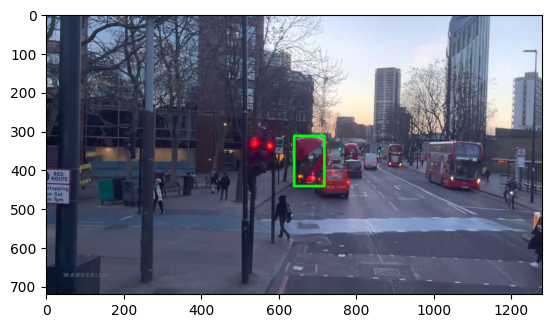

In [9]:
frame = cv2.imread(dataset[0].frames[2])
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

cv2.rectangle(frame, (state[0], state[1]), (state[2] + state[0], state[3] + state[1]),
                         (0, 255, 0), 5)
plt.imshow(frame)

# ProContEXT + SAM

In [10]:
from segment_anything import SamPredictor, sam_model_registry

### Helper function

In [11]:
np.random.seed(200)
_palette = ((np.random.random((3*255))*0.7+0.3)*255).astype(np.uint8).tolist()
_palette = [0,0,0]+_palette

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def save_prediction(pred_mask,output_dir,file_name):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask.save(os.path.join(output_dir,file_name))

In [12]:
sam_checkpoint = "/home/son/Desktop/vot/vot2023/segment-anything/pretrained/sam_vit_l_0b3195.pth"
model_type = "vit_l"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# Predictor
predictor = SamPredictor(sam)

### Runnnn

Init info:  {'init_bbox': [642.0, 315.0, 78.0, 128.0]}
[642.0, 315.0, 78.0, 128.0]
Init info:  {'init_bbox': [694.0, 396.0, 89.0, 76.0]}
[694.0, 396.0, 89.0, 76.0]
1: [array([640, 313, 718, 442]), array([693, 396, 783, 471])]
torch.Size([2, 1, 720, 1280])


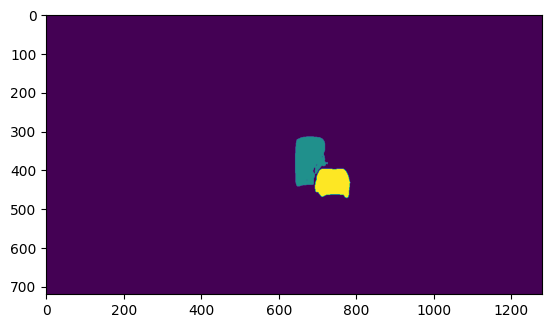

In [14]:
for seq in dataset:
    # Khởi tạo path để lưu output
    output_mask_dir = f'/home/son/Desktop/vot/vot2023/output/test/tracking_sam/{seq.name}'
    if not os.path.exists(output_mask_dir):
        print("[INFO] Making directory...")
        os.makedirs(output_mask_dir, exist_ok=True)
        print("[INFO] Done!")    
    
    trackers = [Tracker(tracker_name, tracker_param, dataset_name, seq, obj_id)
                    for obj_id in range(1, len(seq.init_bbox()) + 1)]
    
    for frame_num, frame_path in enumerate(seq.frames[1:], start=1):
        boxes = []
        for tracker in trackers:
            state = np.array(tracker.track(frame_num, frame_path)) # x, y, w, h
            state[2:] += state[:2]
            boxes.append(state)
        print(f"{frame_num}: {boxes}")
        
        # Running SAM
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        predictor.set_image(frame)
        input_boxes_tensor = torch.tensor(np.array(boxes), device=predictor.device)
        
        transform_boxes = predictor.transform.apply_boxes_torch(input_boxes_tensor, frame.shape[:2])
    
        # Predict mask with SAM
        masks, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transform_boxes,
            multimask_output=False,
        )

        out_mask = np.zeros(masks.shape[-2:]) # masks.shape = [2, 1, 720, 1280]
        
        print(masks.shape)
        for obj_id, mask in enumerate(masks):
            mask = (mask[0] * (obj_id + 1)).numpy()
            out_mask = np.where(mask, mask, out_mask)
        
        plt.imshow(out_mask)
        plt.show()
        
        
        if frame_num == 1:
            break
        

In [48]:
x = [639, 312, 80, 130]
x[2:] += x[:2]
x

[639, 312, 80, 130, 639, 312]

# running_2023.py

In [19]:
print("Evaluating trackers on {:03} sequences".format(len(dataset)))

Evaluating trackers on 001 sequences


In [34]:
mode = 'online'

if mode == 'online':
    print("[INFO] Online tracking mode.")
    
    for seq in dataset:
        trackers = [Tracker(tracker_name, tracker_param, dataset_name, seq, obj_id)
                    for obj_id in range(1, len(seq.init_bbox()) + 1)]
        
    
else: # offline tracking
    pass

[INFO] Online tracking mode.
Init info:  {'init_bbox': [642.0, 315.0, 78.0, 128.0]}
[642.0, 315.0, 78.0, 128.0]
Init info:  {'init_bbox': [694.0, 396.0, 89.0, 76.0]}
[694.0, 396.0, 89.0, 76.0]
[<__main__.Tracker object at 0x7f52840f02d0>, <__main__.Tracker object at 0x7f527c721050>]
